In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.model_selection import ParameterGrid
from datetime import datetime
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings('ignore')

# Fast forecasting – Time series analysis with Facebook Prophet
### Lea Helmers

## Facebook Prophet
* A forecasting tool for R and Python
* Optimized for business forecast tasks encountered at Facebook
     * **Quantitative** forecasting
* Open sourced in February 2017

# What is forecasting useful for?

* Efficient allocation of resources
    * personnel
    * energy
    * transport

* Scheduling of production
    * guidance for long-term strategic planning

* Helps to save resources
* Avoids shortage

# Characteristics of a typical forecasting task

1. **hourly**, **daily**, or **weekly** observations
2. human-scale **seasonalities** 
    * day of week and time of year
  
3. important **holidays** 
    * known in advance (e.g. the Easter, Super Bowl)
  
4. some **missing observations/outliers**
5. historical **trend changes**
6. trends with **non-linear growth** curves

# Forecasting models
## What is out there?

* **Naïve methods**
    * Average of the historical data
    * Value of the last observation
    * Seasonal naïve methods (values of last year)
    

* **ARIMA** (Autoregressive integrated moving average)
    * has to be explicitly extended to capture seasonality
    * prone to trend errors if trend changes near cutoff period

* **Exponential smoothing**
    * has to be explicitly extended to capture seasonality
    * sensitive to end-of-year dip

### Tuning the non-naïve forecasting methods requires thorough understanding of the underlying model

The methods in Fig. 3 generally struggle to produce forecasts that match the characteristics
of these time series. The automatic ARIMA forecasts are prone to large trend
errors when there is a change in trend near the cutoff period and they fail to capture any
seasonality.1 The exponential smoothing and seasonal naive forecasts capture weekly seasonality
but miss longer-term seasonality. All of the methods overreact to the end-of-year
dip because they do not adequately model yearly seasonality.

# Prophet's approach: structural time series model
### $y(t) = g(t) + s(t) + h(t) + \epsilon_t$

* $g(t) \rightarrow$ **growth/trend**
* $s(t) \rightarrow$ **seasonality**
* $h(t) \rightarrow$ **holidays**

# Advantages
### $y(t) = g(t) + s(t) + h(t) + \epsilon_t$
* formulated in terms of independent components

* direct interpretation in terms of quantities of interest
    * Smoothing parameters for single components make model tuning more intuitive

* Flexibility: model different seasonalities and trends
    * Daily, weekly, quarterly, yearly, ...
    * linear vs. logistic trend

* measurements do not need to be regularly spaced
    * Advantage over ARIMA

* Easily extendable to include new components

* Here we use only time as a regressor but possibly several linear and non-linear
functions of time as components. 
* Modeling seasonality as an additive component is the
same approach taken by exponential smoothing (Gardner 1985).

# Illustrative example: Forecasting bikesharing demand in Washington, D.C.

* Hourly renting between 2011 and 2012
* Aggregated on a daily basis: roughly 500 data points

In [3]:
# Load data
df = pd.read_csv("../output/121015_df_bikes_final.csv", 
                 parse_dates=["ds"], sep="\t")
# Log transform
df['y'] = np.log(df['y'])
df[["ds","y"]].head(3)

,ds,y
0,2011-01-01,6.89
1,2011-01-02,6.69
2,2011-01-03,7.21


In [4]:
# Initialize and fit the model
m = Prophet(yearly_seasonality=True)
m.fit(df)

In [5]:
# Create dataframe with future dates
print("Most recent date in data: %s" %str(df.ds.max()))
future = m.make_future_dataframe(periods=365)
future.tail(3)

Most recent date in data: 2012-12-19 00:00:00


,ds
818,2013-12-17
819,2013-12-18
820,2013-12-19


In [6]:
# Forecast...
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
816,2013-12-15,9.04,8.70,9.38
817,2013-12-16,9.11,8.74,9.44
818,2013-12-17,9.10,8.75,9.42
819,2013-12-18,9.07,8.76,9.41
820,2013-12-19,9.13,8.79,9.47


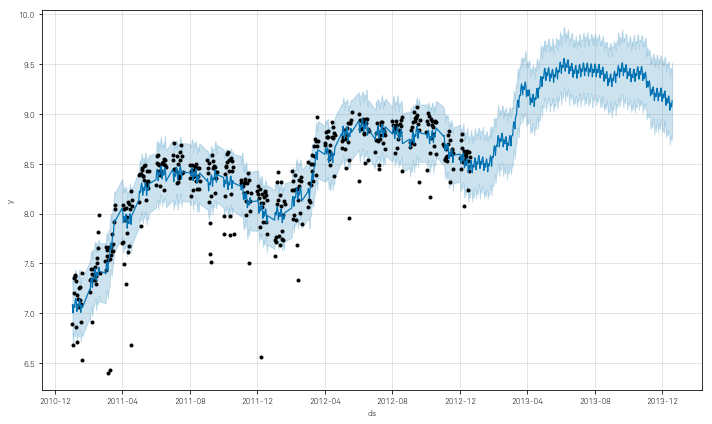

In [114]:
m.plot(forecast)

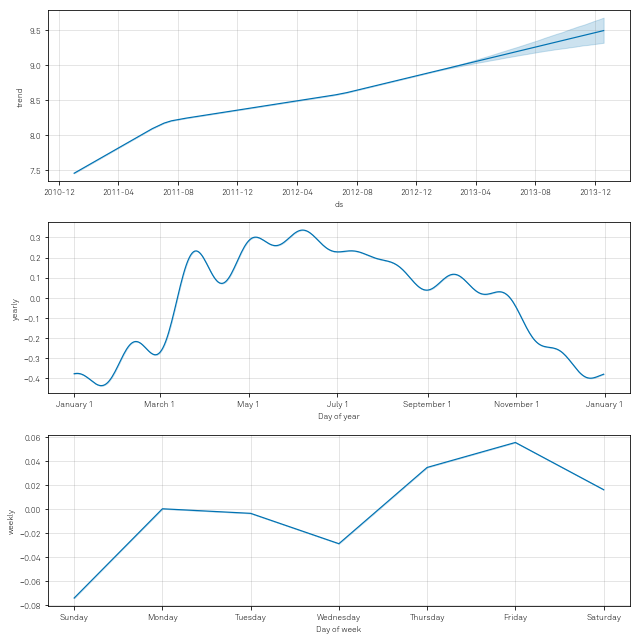

In [115]:
m.plot_components(forecast)

# Modeling the trend
**linear** vs **logistic** growth
* some trends saturate or have a natural limit $\rightarrow$ *logistic* growth
* define a **carrying capacity**
    * total population size
    * total market size
    * $\dots$

# Number of bike users is limited by population size

In [116]:
df_cap = df.copy()

In [117]:
df_cap['cap'] = 9.5
df_cap[["ds", "y", "cap"]].head(3)

,ds,y,cap
0,2011-01-01,6.89,9.50
1,2011-01-02,6.69,9.50
2,2011-01-03,7.21,9.50


In [118]:
m = Prophet(growth='logistic', yearly_seasonality=True)
m.fit(df_cap)

In [119]:
future = m.make_future_dataframe(periods=730)
future['cap'] = 9.5
fcst = m.predict(future)

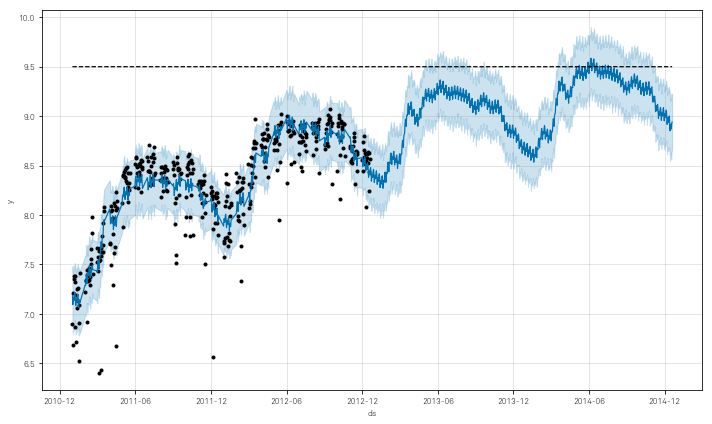

In [120]:
m.plot(fcst)

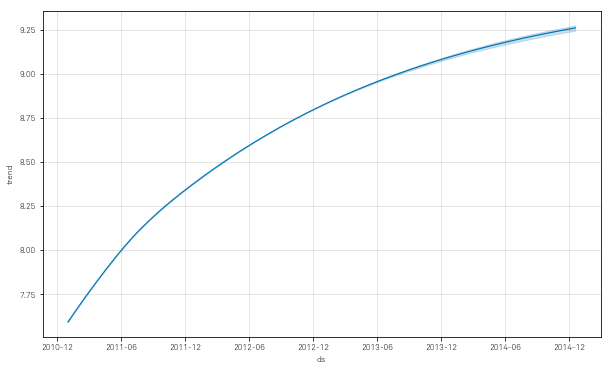

In [134]:
m.plot_forecast_component(fcst, "trend")
plt.show()

# Changepoints
#### Reasons for trend changes
* Product launch
* Governmental incentive
* $\dots$

#### By default determined automatically
number of changepoints can be controlled via hyperparameter **<font color='#912641'>n_changepoints</font>**
```python
m = Prophet(n_changepoints=3)
```

#### Can be set manually by expert
```python
m = Prophet(changepoints=['2014-01-01'])
```

#### Impact can be controlled by hyperparameter **<font color='#912641'>changepoint_prior_scale</font>**

```python
m = Prophet(changepoint_prior_scale=0.05)
```
* Increasing $\rightarrow$ stronger impact (**BEWARE OF OVERFITTING!**)


# Automatic changepoint selection

# Seasonality

* Model periodic changes in the data
* Often **multi-period** seasonality
    * Weekly (e.g. weekend)
    * Yearly (e.g. vacations, temperature)

* Approximate periodic nature of the data with **Fourier series**

 $s(t) = \sum_{n=-N}^N c_n e^{i {2 \pi n t \over P}}$

* $P$ is the regular period of our time series
    * $P = 365.25 \rightarrow$ yearly
    * $P = 7 \rightarrow$ daily

* $N$ is the number of Fourier terms
    * A higher $N$ fits more complex seasonal functions (**BEWARE OF OVERFITTING!**)
        * $N = 10 \rightarrow$ yearly
        * $N = 3 \rightarrow$ daily

* Impact can be controlled by smoothing hyperparameter <font color='#912641'>seasonality_prior_scale</font>
    ```python
    m = Prophet(seasonality_prior_scale=10)
    ```

### Adding seasonalities


* Other seasonalities can be added easily
    ```python
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5,
                      prior_scale=0.01)
    ```

# Holidays
#### Holidays have to be added in a dataframe to the model

In [122]:
import holidays
us_holidays = holidays.US(prov=None, years=np.arange(2011,2018))

In [123]:
df_holidays = pd.DataFrame.from_dict(dict(us_holidays), orient="index")\
                   .reset_index().rename(columns={0:"holiday", "index":"ds"})\
                   .sort_values(by="ds")

In [124]:
df_holidays.head()

,ds,holiday
24,2010-12-31,New Year's Day (Observed)
23,2011-01-01,New Year's Day
25,2011-01-17,"Martin Luther King, Jr. Day"
26,2011-02-21,Washington's Birthday
27,2011-05-30,Memorial Day


<font color='#912641'>prior_scale</font> can be set seperately for each date by adding a respective column $\dots$

In [125]:
df_holidays['prior_scale'] = np.random.rand(df_holidays.shape[0])
df_holidays.head()

,ds,holiday,prior_scale
24,2010-12-31,New Year's Day (Observed),0.32
23,2011-01-01,New Year's Day,0.35
25,2011-01-17,"Martin Luther King, Jr. Day",0.29
26,2011-02-21,Washington's Birthday,0.44
27,2011-05-30,Memorial Day,0.52


$\dots$ Or set to the same value for all holidays
```python
m = Prophet(holidays=df_holidays, holiday_prior_scale=10)
```

# The impact of holiday component can then be inspected

In [129]:
m = Prophet(holidays=df_holidays.drop("prior_scale", 1), holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)

In [131]:
forecast[forecast["Independence Day"] != 0.0][["ds","Independence Day"]]

,ds,Independence Day
117,2011-07-04,0.16
345,2012-07-04,0.16
652,2013-07-04,0.16
1017,2014-07-04,0.16


In [132]:
forecast[forecast["holidays"] != 0.0].set_index("ds")[["holidays"]]\
                                    .join(df_holidays[['ds','holiday']].set_index("ds")).head()

,holidays,holiday
ds,,
2011-01-01,-0.19,New Year's Day
2011-01-17,-0.31,"Martin Luther King, Jr. Day"
2011-07-04,0.16,Independence Day
2011-09-05,-0.14,Labor Day
2011-10-10,0.07,Columbus Day


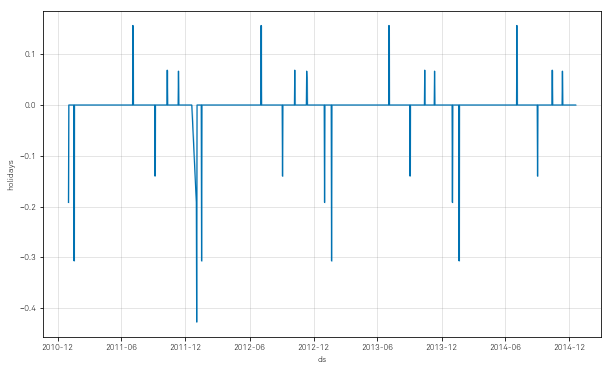

In [133]:
m.plot_forecast_component(forecast, 'holidays')
plt.show()

# Adding regressors to the model
* We have more information in the data set

In [86]:
df.columns

Index(['season', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'casual', 'registered', 'count', 'weather', 'ds', 'y'],
      dtype='object')

## Does the model improve when adding weather condition info?

In [88]:
df_train = df.iloc[:300,:]
df_test = df.iloc[300:,:]

In [87]:
m = Prophet(yearly_seasonality=True)

In [89]:
m.fit(df_train)
forecast = m.predict(df_train.append(df_test))

In [90]:
mean_absolute_error(df_test.y, forecast.iloc[300:,:].yhat)

0.41191627806470577

In [91]:
m = Prophet(yearly_seasonality=True)
m.add_regressor('weather_2', prior_scale=0.1)

In [93]:
m.fit(df_train)
forecast = m.predict(df_train.append(df_test))

In [94]:
mean_absolute_error(df_test.y, forecast.iloc[300:,:].yhat)

0.38795295262310714

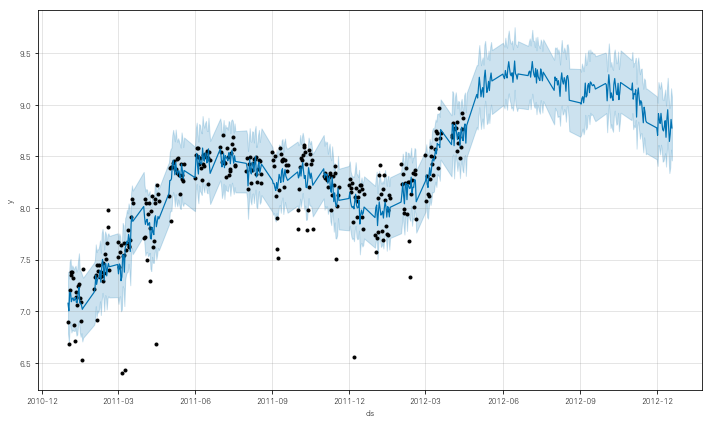

In [95]:
m.plot(forecast)

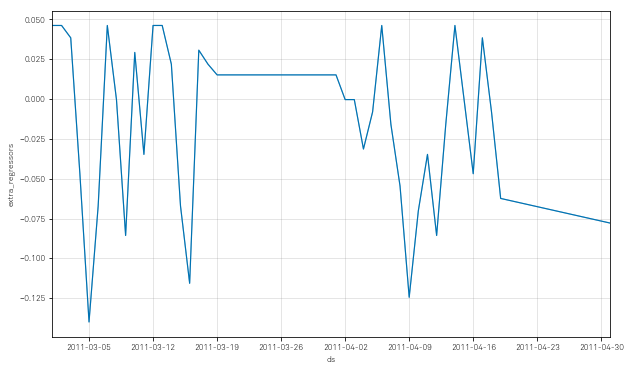

In [97]:
m.plot_forecast_component(forecast, "extra_regressors")
plt.xlim(datetime(2011,3,1), datetime(2011,5,1))
plt.show()

In [98]:
forecast["ds_short"] = forecast.ds.map(lambda x: x.date())

In [101]:
df["ds"] = df.ds.map(lambda x: x.date())

In [102]:
fcst_info = forecast.join(df[["ds", "weather_2"]].set_index("ds"), on="ds_short", rsuffix="_data")

In [104]:
fcst_info[["weather_2_data", "extra_regressors"]].head(10)

,weather_2_data,extra_regressors
0,0.42,-0.03
1,0.52,-0.05
2,0.00,0.05
3,0.04,0.04
4,0.00,0.05
5,0.35,-0.02
6,0.61,-0.07
7,0.38,-0.02
8,0.00,0.05
9,0.33,-0.02


# Uncertainty intervals
#### Sources of uncertainty:
1. uncertainty in the trend
2. uncertainty in the seasonality estimates
3. additional observation noise

#### By default, only the uncertainty in trend is modeled

#### Assumption: future frequency and magnitude of trend changes will be the same as in history
* project historical trend changes forward
* computing their distribution to obtain uncertainty intervals

In [7]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
818,2013-12-17,9.10,8.75,9.42
819,2013-12-18,9.07,8.76,9.41
820,2013-12-19,9.13,8.79,9.47


# Model selection and evaluation
* Cross validation with rolling forecasting origins is implemented

In [138]:
from IPython.display import Image
crossval = Image(filename='../output/figs/fb_prophet_crossval.png')

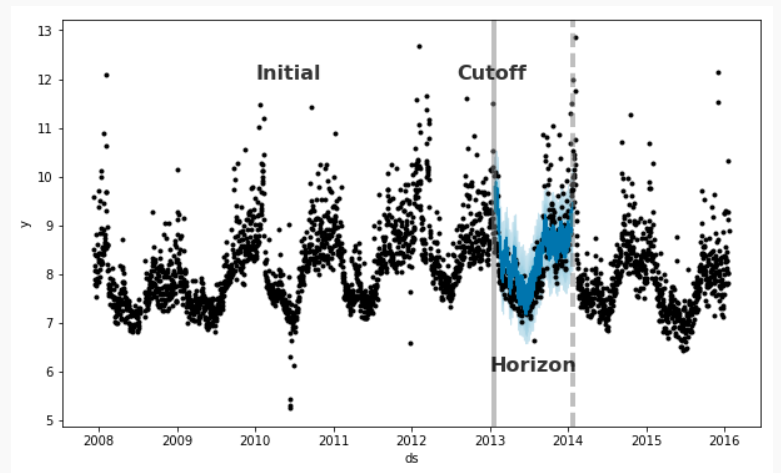

In [139]:
crossval

* Grid search is easy to implement


### References
* Taylor SJ, Letham B. (2017) Forecasting at scale. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2
* https://facebook.github.io/prophet/docs/quick_start.html
* Harvey, A. & Peters, S. (1990), *Estimation procedures for structural time series models*, Journal of Forecasting 9, 89–108.
* Blog post by José Roberto Ayala S: https://medium.com/towards-data-science/playing-with-prophet-on-bike-sharing-demand-time-series-1f14255f7ff0
* Kaggle bike sharing competition: https://www.kaggle.com/c/bike-sharing-demand

# Prepare data
* Convert it from hourly to daily data

In [5]:
df_bikes = pd.read_csv("../data/bikesharing_train.csv")

In [6]:
df_bikes["datetime"] = df_bikes.datetime.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [7]:
df_bikes["day"] = df_bikes.datetime.map(lambda x: x.date())

In [8]:
df_bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01


In [9]:
weather_dummy = pd.get_dummies(df_bikes.weather, prefix = "weather")

In [10]:
df_bikes_dum = df_bikes.drop("weather", 1).join(weather_dummy)

In [11]:
df_bikes_mean = df_bikes_dum[["day",
                              "season", "holiday", "workingday", "temp", "atemp", "humidity", "windspeed",
                             "weather_1", "weather_2", "weather_3", "weather_4"]].groupby("day").mean()

In [12]:
df_bikes_sum = df_bikes_dum[["day", "casual", "registered", "count"]].groupby("day").sum()

In [13]:
df_bikes_sum.shape

(456, 3)

In [14]:
df_bikes_mean.shape

(456, 11)

In [15]:
df_bikes_final = df_bikes_mean.join(df_bikes_sum)

In [16]:
df_bikes_final = df_bikes_final.join(df_bikes.groupby("day").max()["weather"])

In [17]:
df_bikes_final["ds"] = df_bikes_final.index.values

In [18]:
df_bikes_final["y"] = df_bikes_final["count"]

In [19]:
df_bikes_final.head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,weather_1,weather_2,weather_3,weather_4,casual,registered,count,weather,ds,y
day,,,,,,,,,,,,,,,,,
2011-01-01,1.0,0.0,0.0,14.110833,18.181250,80.583333,10.749871,0.500000,0.416667,0.083333,0.0,331,654,985,3,2011-01-01,985
2011-01-02,1.0,0.0,0.0,14.902609,17.686957,69.608696,16.652122,0.260870,0.521739,0.217391,0.0,131,670,801,3,2011-01-02,801
2011-01-03,1.0,0.0,1.0,8.050909,9.470227,43.727273,16.636709,1.000000,0.000000,0.000000,0.0,120,1229,1349,1,2011-01-03,1349
2011-01-04,1.0,0.0,1.0,8.200000,10.606087,59.043478,10.739809,0.956522,0.043478,0.000000,0.0,108,1454,1562,2,2011-01-04,1562
2011-01-05,1.0,0.0,1.0,9.305217,11.463478,43.695652,12.522300,1.000000,0.000000,0.000000,0.0,82,1518,1600,1,2011-01-05,1600


In [ ]:
df_bikes_final.to_csv("../output/121015_df_bikes_final.csv", sep="\t", index=False)

# Forecast

In [318]:
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [319]:
results = {}

In [323]:
for param, vals in prophet_grid.items():
    grid = ParameterGrid(prophet_grid)
    for param_combi in grid:
        if param_combi["growth"] == 'logistic':
            train["cap"] = param_combi["capacity"]
            test["cap"] = param_combi["capacity"]
            m = Prophet(**{key: val for key, val in param_combi.items() if key != "capacity"})
        else:
            m = Prophet(**{key: val for key, val in param_combi.items() if key != "capacity"})
        m.fit(train)
        #pred = m.predict(test)
        df_cv = cross_validation(m, horizon='90 days')
        results["_".join([str(x) for x in param_combi.values()]) + "_mae"] = mean_absolute_error(df_cv.y, df_cv.yhat)#mean_absolute_error(test.y, pred.yhat)
        results["_".join([str(x) for x in param_combi.values()]) + "_rmsle"] = rmsle(df_cv.yhat, df_cv.y)#rmsle(pred.yhat, test.y)

In [324]:
df_results = pd.DataFrame.from_dict(results, orient='index')

In [325]:
df_results["score"] = df_results.index.map(lambda x: x.split("_")[-1])

In [326]:
df_results_mae = df_results[df_results.score == "mae"]

In [327]:
df_results_rmsle = df_results[df_results.score == "rmsle"]

In [328]:
df_results_rmsle.sort_values(by=0).head()

,0,score
8000_1_logistic_0.1_1_rmsle,0.506062,rmsle
8000_1_logistic_1_1_rmsle,0.506062,rmsle
8000_1_logistic_10_1_rmsle,0.506062,rmsle
8000_1_logistic_0.1_10_rmsle,0.509181,rmsle
8000_1_logistic_10_10_rmsle,0.509181,rmsle


In [329]:
df_results_mae.sort_values(by=0).head()

,0,score
8000_1_logistic_10_1_mae,1445.954874,mae
8000_1_logistic_1_1_mae,1445.954874,mae
8000_1_logistic_0.1_1_mae,1445.954874,mae
8000_1_logistic_10_10_mae,1447.816726,mae
8000_1_logistic_1_10_mae,1447.816726,mae
